In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                             mean_absolute_percentage_error, confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             balanced_accuracy_score, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)
import tqdm as tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Вероятно всего при обучении модели колонки "PassengerId", "Name" и "Ticket" нам не сообщат ничего о том, смог ли выжить человек на Титанике или же нет. Поэтому, чтобы не перегружать нашу модель, удалим эти столбцы**.

In [3]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


**Теперь можно выделить target, то есть колонку "Survived"**.

In [4]:
y = df['Survived']

#удаляем наш таргет из общего датафрейма

df = df.drop(['Survived'], axis = 1)

df

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,NaN,S
887,1,female,19.0,0,0,30.0000,B42,S
888,3,female,NaN,1,2,23.4500,NaN,S
889,1,male,26.0,0,0,30.0000,C148,C


In [5]:
df.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [6]:
df.shape

(891, 8)

In [7]:
df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'], dtype='object')

**Проверим наш DataFrame на пропуски (NaN), проверим в каких именно столбцах они содержаться.**

In [8]:
df.columns[df.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

**Начинаем заполнять пропуски в наших данных.**

In [9]:
#Заполняем пропуски в столбце Age, для этого будем использовать медиану.
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Age'].tail()
#При проверке конечной части датафрейма, видим, что строка 888 приняла значение нашей медианы (28)

886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, dtype: float64

In [10]:
#Заполняем пропуски в столбце Embarked, здесь признак уже категориальный, будем использовать метод .value_counts().
df['Embarked'].value_counts()

#Заполним тем значением, которое встречается больше всего в выборке, т.е. S

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
df['Embarked'] = df['Embarked'].fillna('S')
df['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

**Со столбцом Cabin не все так однозначно, т.к. в нем весьма много пропусков, узнать это можно следующим образом**

In [12]:
print('Пропущенных значений: ' + str(df['Cabin'].isna().sum()))
print('Всего значений: '+ str(len(df)))

Пропущенных значений: 687
Всего значений: 891


**Пропущенных значений > 50%. Будет целесообразно дропнуть эту колонку**

In [13]:
df = df.drop(['Cabin'], axis = 1)

df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,28.0,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


Для дальнейшей работы, нам также нужно категориальные признаки перевести в числовые.

In [14]:
df.dtypes # категориальные признаки - это "Sex" и "Embarked"

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [15]:
df['Sex'].describe()

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object

**В признаке пол у нас всего 2 варианта - мужской и женский, поэтому мы можем эти значения заменить на числа 0 и 1, где где 0 - это женщины, а 1 - это мужчины**

In [16]:
df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,S
1,1,0,38.0,1,0,71.2833,C
2,3,0,26.0,0,0,7.9250,S
3,1,0,35.0,1,0,53.1000,S
4,3,1,35.0,0,0,8.0500,S


In [17]:
df['Embarked'].describe()

count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

**Мы могли бы по аналогии поступить и с колонкой 'Embarked', но тут уже содержится 3 уникальных значения, а не 2. Для этого мы можем разбить нашу колонку на 3 новых колонки с бинарными значениями.**

In [18]:
df = pd.get_dummies(df, columns=['Embarked'])
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.0,1,0,7.2500,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0
2,3,0,26.0,0,0,7.9250,0,0,1
3,1,0,35.0,1,0,53.1000,0,0,1
4,3,1,35.0,0,0,8.0500,0,0,1


In [27]:
X = df

In [28]:
# Разбиваем датасет на тренировочный и валидационный.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
# model = KNeighborsClassifier(n_neighbors=3)
# model.fit(X_train, y_train)

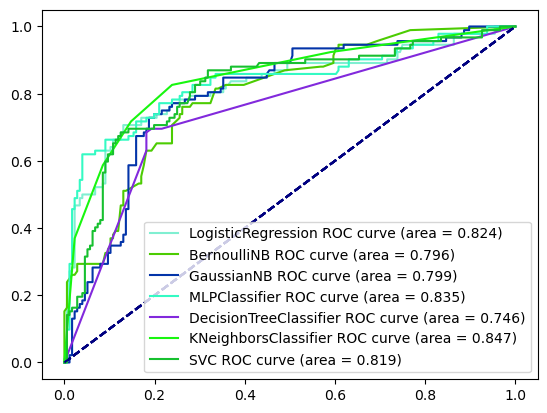

In [29]:
def try_model(model, X_train, y_train, X_test, y_test, plot_flag=False, model_params=None):
    if model_params is None:
        model_params = dict()
    pipeline = make_pipeline(StandardScaler(), model(**model_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, 
             color=np.random.rand(3,), 
             label=f"{model.__name__} ROC curve (area = {auc(fpr, tpr):0.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.legend()
    
    if plot_flag:
        plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
        plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
        plt.legend()

        ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

    return pipeline, model.__name__, (acc, precision, recall, f1, roc_auc)

result = []
result.append(try_model(LogisticRegression, X_train, y_train, X_test, y_test))
result.append(try_model(BernoulliNB, X_train, y_train, X_test, y_test))
result.append(try_model(GaussianNB, X_train, y_train, X_test, y_test))
result.append(try_model(MLPClassifier, X_train, y_train, X_test, y_test))
result.append(try_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test))
result.append(try_model(KNeighborsClassifier, X_train, y_train, X_test, y_test))
result.append(try_model(SVC, X_train, y_train, X_test, y_test,
          model_params=dict(
            kernel='linear',
            probability=True,
)))

In [30]:
# Выведем нашу отчетную таблицу
(pd.DataFrame(data=[x[2] for x in result],
                     columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC-AUC'],
                     index=[x[1] for x in result])
    .sort_values(by='ROC-AUC', ascending=False)
)

,Accuracy,Precision,Recall,F1 score,ROC-AUC
KNeighborsClassifier,0.805970,0.717391,0.717391,0.717391,0.784832
MLPClassifier,0.817164,0.772152,0.663043,0.713450,0.780385
LogisticRegression,0.783582,0.670000,0.728261,0.697917,0.770380
SVC,0.787313,0.688172,0.695652,0.691892,0.765440
DecisionTreeClassifier,0.772388,0.663158,0.684783,0.673797,0.751482
GaussianNB,0.772388,0.666667,0.673913,0.670270,0.748888
BernoulliNB,0.746269,0.625000,0.652174,0.638298,0.723814


**Как видно из таблицы выше, по всем метрикам наилучший результат продемонстрировала модель MLPClassifier**

(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('mlpclassifier', MLPClassifier())]),
 'MLPClassifier',
 (0.8171641791044776,
  0.7721518987341772,
  0.6630434782608695,
  0.7134502923976608,
  0.780385375494071))

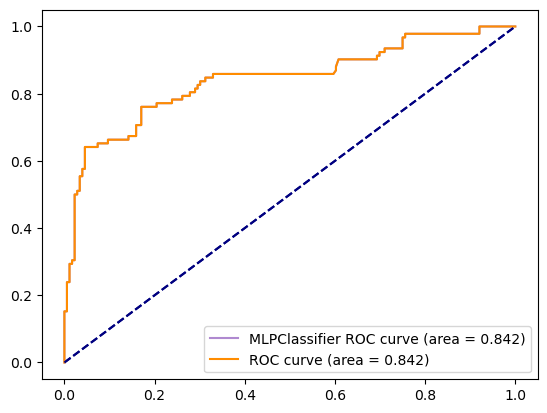

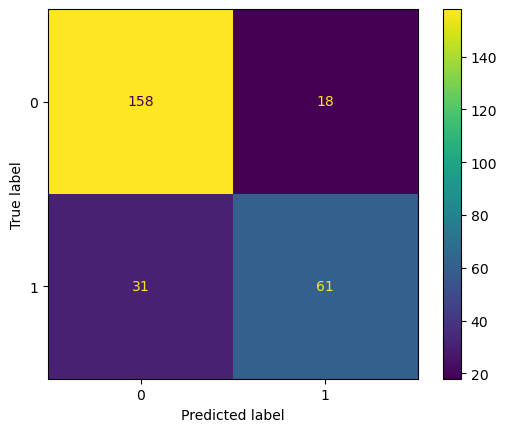

In [31]:
try_model(MLPClassifier, X_train, y_train, X_test, y_test, plot_flag=True, model_params=None)

##  <center> Объяснение выборки метрик </center>
- accuracy_score - показывает отношение "попаданий" (TP+TN) к общему количеству предсказаний
- precision_score (точность) - доля ожидаемых положительных событий, которые на самом деле являются положительными (TP / (TP+FP))
- recall_score (чувствительность) - доля положительных событий, которые вы правильно предсказали (TP / (TP+FN))
- f1_score - гармоническое среднее чувствительности и точности
- ROC AUC - кривые ROC очень помогают понять баланс между истинно положительными показателями и ложноположительными показателями